# Face Generation
We use generative adversarial networks to generate new images of faces.
### Get the Data
We'll be using two datasets in this project:
- MNIST
- CelebA

If using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'

import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Exploring the Data
### MNIST
The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. 

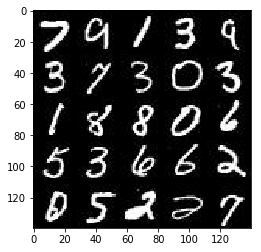

In [2]:
show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since we're going to be generating faces, we won't need the annotations.  

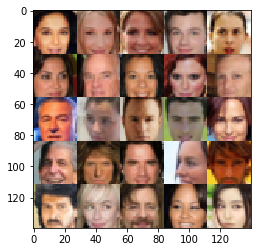

In [3]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocessing the Data
The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28. The preprocessing scripts are by Udacity. 

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
We'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
Check to make sure have the correct version of TensorFlow and access to a GPU

In [4]:

from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implementing the `model_inputs` function to create TF Placeholders for the Neural Network to create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Returns the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
   
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate_ = tf.placeholder(tf.float32, name='learn_rate')
    return inputs_real, inputs_z, learning_rate_


tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implements `discriminator` to create a discriminator neural network that discriminates on `images`.  This function is able to reuse the variabes in the neural network;  uses [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function returns a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def leakyRelu(x, alpha):
    return tf.maximum(alpha*x,x)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28
        #l1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
        #                     kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        l1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = leakyRelu(l1,0.1)
        relu1 = tf.nn.dropout(relu1, 0.8)
        # 14x14x64
        
        #l2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
        #                     kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        l2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(l2, training=True)
        relu2 = leakyRelu(bn2,0.1)
        relu2 = tf.nn.dropout(relu2, 0.8)
        # 7x7x128
        
        l3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(l3, training=True)
        relu3 = leakyRelu(bn3,0.1)
        relu3 = tf.nn.dropout(relu3, 0.8)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1,
                                kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        logits = tf.nn.dropout(logits, 0.9)
        out = tf.sigmoid(logits)
    
    return out, logits

 
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implements `generator` to generate an image using `z`. This function reuses the variabes in the neural network;  uses [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator". The function returns the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        l1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        l1 = tf.reshape(l1, (-1, 7, 7, 512))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = leakyRelu(l1,0.1)
        l1 = tf.nn.dropout(l1, 0.8)
        
        # 7x7x512
        #l2 = tf.layers.conv2d_transpose(l1, 256, 5, strides=2, padding='same',
        #                               kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        l2 = tf.layers.conv2d_transpose(l1, 256, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = leakyRelu(l2,0.1)
        l2 = tf.nn.dropout(l2, 0.8)
        
        # 14x14x256
        #l3 = tf.layers.conv2d_transpose(l2, 128, 5, strides=2, padding='same',
        #                               kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        l3 = tf.layers.conv2d_transpose(l2, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        l3 = leakyRelu(l3,0.1)
        l3 = tf.nn.dropout(l3, 0.8)
        # 28x28x128 Now
        
        # Output Layer
        #logits = tf.layers.conv2d_transpose(l3, out_channel_dim, 5, strides=1, padding='same',
        #                                   kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        logits = tf.layers.conv2d_transpose(l3, out_channel_dim, 5, strides=1, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 Now     
        out = tf.tanh(logits)
       
    
    return out

tests.test_generator(generator, tf)

Tests Passed


### Loss
Implements `model_loss` to build the GANs for training and calculate the loss.  The function returns a tuple of (discriminator loss, generator loss).  Uses the following functions:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implements `model_opt` to create the optimization operations for the GANs. Uses [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filters the variables with names that are in the discriminator and generator scope names.  The function returns a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Shows Output
Function to show the current output of the generator during training. 

In [10]:

import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implements `train` to build and train the GANs.  Uses the following functions:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Uses the `show_generator_output` to show `generator` output while training.  We print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    _, width, height, depth = data_shape
    input_real, input_z, learning_rate_ = model_inputs(width, height, depth, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, depth)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_, beta1)
    
    saver = tf.train.Saver()
    num_steps = 0
    losses = []

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
              
                num_steps += 1
                batch_images *= 2 #change to -1 to 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
               
                _ = sess.run(d_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               learning_rate_: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               learning_rate_: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               learning_rate_: learning_rate})
                
                if num_steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images,
                                               input_z: batch_z,
                                               learning_rate_: learning_rate})
                    train_loss_g = g_loss.eval({input_real: batch_images,
                                               input_z: batch_z,
                                               learning_rate_: learning_rate})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if num_steps % 100 == 0:
                    show_generator_output(sess, 10, input_z, depth, data_image_mode)
        
    return losses
                    
                

### MNIST
Tests the GANs architecture on MNIST.  

Epoch 1/2... Discriminator Loss: 2.3700... Generator Loss: 0.5185
Epoch 1/2... Discriminator Loss: 1.9161... Generator Loss: 0.5103
Epoch 1/2... Discriminator Loss: 1.8003... Generator Loss: 0.6467
Epoch 1/2... Discriminator Loss: 1.5457... Generator Loss: 1.0507
Epoch 1/2... Discriminator Loss: 1.5829... Generator Loss: 0.9113
Epoch 1/2... Discriminator Loss: 1.5730... Generator Loss: 0.6497
Epoch 1/2... Discriminator Loss: 1.5049... Generator Loss: 0.6812
Epoch 1/2... Discriminator Loss: 1.7064... Generator Loss: 1.1704
Epoch 1/2... Discriminator Loss: 1.5789... Generator Loss: 0.8166
Epoch 1/2... Discriminator Loss: 1.5344... Generator Loss: 1.0652


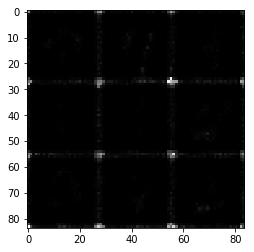

Epoch 1/2... Discriminator Loss: 1.5253... Generator Loss: 0.6825
Epoch 1/2... Discriminator Loss: 1.3793... Generator Loss: 0.7836
Epoch 1/2... Discriminator Loss: 1.3684... Generator Loss: 0.7701
Epoch 1/2... Discriminator Loss: 1.3974... Generator Loss: 0.9283
Epoch 1/2... Discriminator Loss: 1.3884... Generator Loss: 1.0076
Epoch 1/2... Discriminator Loss: 1.5113... Generator Loss: 1.0164
Epoch 1/2... Discriminator Loss: 1.5430... Generator Loss: 0.6715
Epoch 1/2... Discriminator Loss: 1.5148... Generator Loss: 0.5672
Epoch 1/2... Discriminator Loss: 1.4106... Generator Loss: 0.9354
Epoch 1/2... Discriminator Loss: 1.5701... Generator Loss: 0.5978
Epoch 1/2... Discriminator Loss: 1.4688... Generator Loss: 1.2810
Epoch 1/2... Discriminator Loss: 1.3847... Generator Loss: 0.6576
Epoch 1/2... Discriminator Loss: 1.3097... Generator Loss: 0.8502
Epoch 1/2... Discriminator Loss: 1.4218... Generator Loss: 0.6979
Epoch 1/2... Discriminator Loss: 1.3865... Generator Loss: 0.9171
Epoch 1/2.

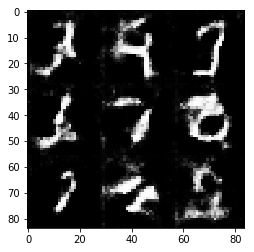

Epoch 1/2... Discriminator Loss: 1.5276... Generator Loss: 0.6677
Epoch 1/2... Discriminator Loss: 1.4758... Generator Loss: 1.0624
Epoch 1/2... Discriminator Loss: 1.3835... Generator Loss: 0.9820
Epoch 1/2... Discriminator Loss: 1.4352... Generator Loss: 1.0649
Epoch 1/2... Discriminator Loss: 1.3414... Generator Loss: 0.8385
Epoch 1/2... Discriminator Loss: 1.4067... Generator Loss: 0.8345
Epoch 1/2... Discriminator Loss: 1.3996... Generator Loss: 1.0669
Epoch 1/2... Discriminator Loss: 1.2200... Generator Loss: 1.0522
Epoch 1/2... Discriminator Loss: 1.3257... Generator Loss: 0.9080
Epoch 1/2... Discriminator Loss: 1.4091... Generator Loss: 0.6281


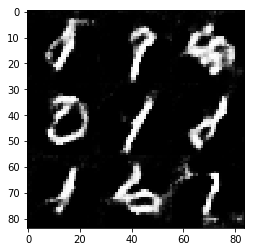

Epoch 1/2... Discriminator Loss: 1.3036... Generator Loss: 0.7362
Epoch 1/2... Discriminator Loss: 1.2983... Generator Loss: 1.0146
Epoch 1/2... Discriminator Loss: 1.5072... Generator Loss: 0.6339
Epoch 1/2... Discriminator Loss: 1.4078... Generator Loss: 0.5978
Epoch 1/2... Discriminator Loss: 1.3546... Generator Loss: 0.9689
Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.7079
Epoch 1/2... Discriminator Loss: 1.4027... Generator Loss: 0.7981
Epoch 1/2... Discriminator Loss: 1.3733... Generator Loss: 1.0731
Epoch 1/2... Discriminator Loss: 1.4123... Generator Loss: 0.7659
Epoch 1/2... Discriminator Loss: 1.2668... Generator Loss: 0.9104


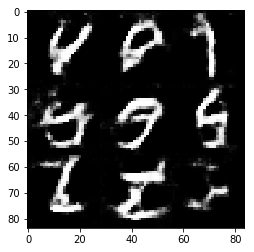

Epoch 1/2... Discriminator Loss: 1.3150... Generator Loss: 0.9844
Epoch 1/2... Discriminator Loss: 1.3594... Generator Loss: 0.8614
Epoch 1/2... Discriminator Loss: 1.3583... Generator Loss: 0.8091
Epoch 1/2... Discriminator Loss: 1.3323... Generator Loss: 0.8734
Epoch 1/2... Discriminator Loss: 1.4429... Generator Loss: 0.6768
Epoch 1/2... Discriminator Loss: 1.3613... Generator Loss: 0.8749
Epoch 1/2... Discriminator Loss: 1.3296... Generator Loss: 0.8179
Epoch 1/2... Discriminator Loss: 1.3478... Generator Loss: 0.8382
Epoch 1/2... Discriminator Loss: 1.3339... Generator Loss: 0.7307
Epoch 1/2... Discriminator Loss: 1.3300... Generator Loss: 1.0102


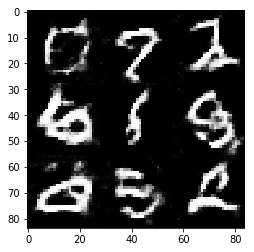

Epoch 1/2... Discriminator Loss: 1.3469... Generator Loss: 1.0052
Epoch 1/2... Discriminator Loss: 1.2607... Generator Loss: 0.8575
Epoch 1/2... Discriminator Loss: 1.3210... Generator Loss: 0.9468
Epoch 1/2... Discriminator Loss: 1.3010... Generator Loss: 0.7919
Epoch 1/2... Discriminator Loss: 1.2362... Generator Loss: 0.8612
Epoch 1/2... Discriminator Loss: 1.3980... Generator Loss: 0.8891
Epoch 1/2... Discriminator Loss: 1.3040... Generator Loss: 0.8633
Epoch 1/2... Discriminator Loss: 1.3541... Generator Loss: 0.9068
Epoch 1/2... Discriminator Loss: 1.3387... Generator Loss: 0.8309
Epoch 1/2... Discriminator Loss: 1.2675... Generator Loss: 1.0296


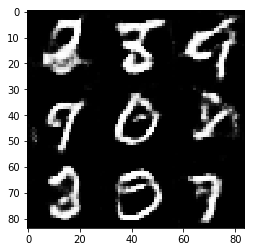

Epoch 1/2... Discriminator Loss: 1.2963... Generator Loss: 1.1081
Epoch 1/2... Discriminator Loss: 1.3495... Generator Loss: 0.9645
Epoch 1/2... Discriminator Loss: 1.3531... Generator Loss: 0.8455
Epoch 1/2... Discriminator Loss: 1.3520... Generator Loss: 0.8226
Epoch 1/2... Discriminator Loss: 1.3674... Generator Loss: 0.7433
Epoch 1/2... Discriminator Loss: 1.3446... Generator Loss: 1.0036
Epoch 1/2... Discriminator Loss: 1.4458... Generator Loss: 0.7574
Epoch 1/2... Discriminator Loss: 1.3834... Generator Loss: 1.0839
Epoch 1/2... Discriminator Loss: 1.4078... Generator Loss: 0.8111
Epoch 1/2... Discriminator Loss: 1.3374... Generator Loss: 0.8151


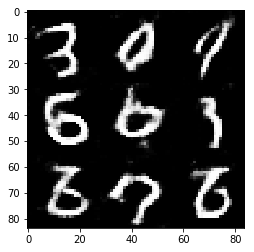

Epoch 1/2... Discriminator Loss: 1.3551... Generator Loss: 0.9351
Epoch 1/2... Discriminator Loss: 1.4292... Generator Loss: 0.9753
Epoch 1/2... Discriminator Loss: 1.3514... Generator Loss: 0.6790
Epoch 1/2... Discriminator Loss: 1.3831... Generator Loss: 0.5842
Epoch 1/2... Discriminator Loss: 1.4190... Generator Loss: 0.5948
Epoch 1/2... Discriminator Loss: 1.3208... Generator Loss: 0.8732
Epoch 1/2... Discriminator Loss: 1.2633... Generator Loss: 0.8223
Epoch 1/2... Discriminator Loss: 1.3967... Generator Loss: 0.7510
Epoch 1/2... Discriminator Loss: 1.3753... Generator Loss: 0.8087
Epoch 1/2... Discriminator Loss: 1.4666... Generator Loss: 0.6111


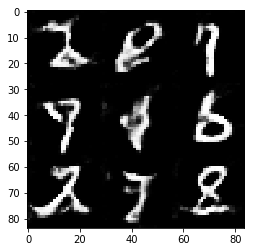

Epoch 1/2... Discriminator Loss: 1.3470... Generator Loss: 1.0155
Epoch 1/2... Discriminator Loss: 1.2740... Generator Loss: 0.8820
Epoch 1/2... Discriminator Loss: 1.2963... Generator Loss: 1.0090
Epoch 2/2... Discriminator Loss: 1.3935... Generator Loss: 0.8406
Epoch 2/2... Discriminator Loss: 1.2580... Generator Loss: 0.8698
Epoch 2/2... Discriminator Loss: 1.3354... Generator Loss: 0.8045
Epoch 2/2... Discriminator Loss: 1.3441... Generator Loss: 0.6496
Epoch 2/2... Discriminator Loss: 1.2799... Generator Loss: 1.0017
Epoch 2/2... Discriminator Loss: 1.3877... Generator Loss: 1.0421
Epoch 2/2... Discriminator Loss: 1.3586... Generator Loss: 0.8814


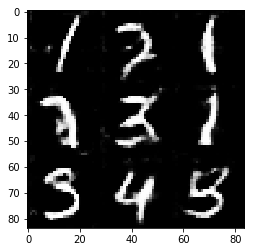

Epoch 2/2... Discriminator Loss: 1.4042... Generator Loss: 1.2686
Epoch 2/2... Discriminator Loss: 1.4202... Generator Loss: 0.8979
Epoch 2/2... Discriminator Loss: 1.3339... Generator Loss: 0.8404
Epoch 2/2... Discriminator Loss: 1.2593... Generator Loss: 0.9471
Epoch 2/2... Discriminator Loss: 1.3552... Generator Loss: 0.8831
Epoch 2/2... Discriminator Loss: 1.3766... Generator Loss: 0.7312
Epoch 2/2... Discriminator Loss: 1.4098... Generator Loss: 0.7121
Epoch 2/2... Discriminator Loss: 1.2440... Generator Loss: 0.9209
Epoch 2/2... Discriminator Loss: 1.3728... Generator Loss: 0.8486
Epoch 2/2... Discriminator Loss: 1.2742... Generator Loss: 0.7515


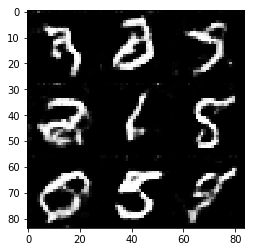

Epoch 2/2... Discriminator Loss: 1.3292... Generator Loss: 0.9192
Epoch 2/2... Discriminator Loss: 1.3789... Generator Loss: 1.0181
Epoch 2/2... Discriminator Loss: 1.3598... Generator Loss: 0.6294
Epoch 2/2... Discriminator Loss: 1.3545... Generator Loss: 0.7145
Epoch 2/2... Discriminator Loss: 1.3588... Generator Loss: 0.8284
Epoch 2/2... Discriminator Loss: 1.2620... Generator Loss: 0.9366
Epoch 2/2... Discriminator Loss: 1.4232... Generator Loss: 0.7509
Epoch 2/2... Discriminator Loss: 1.4191... Generator Loss: 0.9846
Epoch 2/2... Discriminator Loss: 1.3150... Generator Loss: 0.9101
Epoch 2/2... Discriminator Loss: 1.3108... Generator Loss: 0.9345


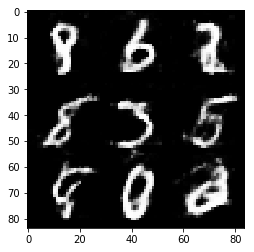

Epoch 2/2... Discriminator Loss: 1.3332... Generator Loss: 0.8503
Epoch 2/2... Discriminator Loss: 1.4482... Generator Loss: 0.7082
Epoch 2/2... Discriminator Loss: 1.3136... Generator Loss: 0.9048
Epoch 2/2... Discriminator Loss: 1.3792... Generator Loss: 0.9833
Epoch 2/2... Discriminator Loss: 1.3321... Generator Loss: 0.9247
Epoch 2/2... Discriminator Loss: 1.3509... Generator Loss: 0.9062
Epoch 2/2... Discriminator Loss: 1.3231... Generator Loss: 0.8957
Epoch 2/2... Discriminator Loss: 1.2840... Generator Loss: 0.7549
Epoch 2/2... Discriminator Loss: 1.5255... Generator Loss: 0.7769
Epoch 2/2... Discriminator Loss: 1.4538... Generator Loss: 0.6942


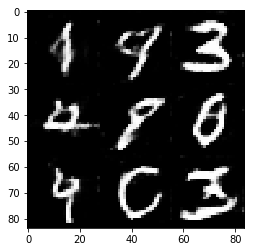

Epoch 2/2... Discriminator Loss: 1.3898... Generator Loss: 0.8764
Epoch 2/2... Discriminator Loss: 1.3173... Generator Loss: 0.9487
Epoch 2/2... Discriminator Loss: 1.3287... Generator Loss: 0.8968
Epoch 2/2... Discriminator Loss: 1.3513... Generator Loss: 0.8079
Epoch 2/2... Discriminator Loss: 1.3753... Generator Loss: 0.8458
Epoch 2/2... Discriminator Loss: 1.4021... Generator Loss: 0.6731
Epoch 2/2... Discriminator Loss: 1.3291... Generator Loss: 0.8951
Epoch 2/2... Discriminator Loss: 1.4120... Generator Loss: 0.7459
Epoch 2/2... Discriminator Loss: 1.3005... Generator Loss: 0.9730
Epoch 2/2... Discriminator Loss: 1.3838... Generator Loss: 0.8777


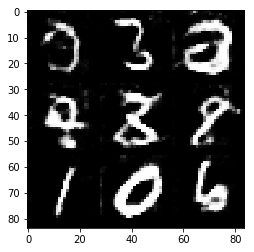

Epoch 2/2... Discriminator Loss: 1.3800... Generator Loss: 0.8895
Epoch 2/2... Discriminator Loss: 1.3039... Generator Loss: 1.0140
Epoch 2/2... Discriminator Loss: 1.3754... Generator Loss: 0.6555
Epoch 2/2... Discriminator Loss: 1.2599... Generator Loss: 0.9001
Epoch 2/2... Discriminator Loss: 1.2990... Generator Loss: 0.9542
Epoch 2/2... Discriminator Loss: 1.3717... Generator Loss: 0.6769
Epoch 2/2... Discriminator Loss: 1.2903... Generator Loss: 0.9888
Epoch 2/2... Discriminator Loss: 1.4037... Generator Loss: 0.9117
Epoch 2/2... Discriminator Loss: 1.3919... Generator Loss: 0.6585
Epoch 2/2... Discriminator Loss: 1.4623... Generator Loss: 0.6764


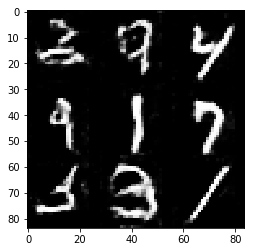

Epoch 2/2... Discriminator Loss: 1.3873... Generator Loss: 0.7246
Epoch 2/2... Discriminator Loss: 1.3478... Generator Loss: 0.8348
Epoch 2/2... Discriminator Loss: 1.3411... Generator Loss: 0.8376
Epoch 2/2... Discriminator Loss: 1.3582... Generator Loss: 0.9315
Epoch 2/2... Discriminator Loss: 1.2889... Generator Loss: 0.8027
Epoch 2/2... Discriminator Loss: 1.4238... Generator Loss: 0.9674
Epoch 2/2... Discriminator Loss: 1.3631... Generator Loss: 0.8290
Epoch 2/2... Discriminator Loss: 1.3139... Generator Loss: 0.8882
Epoch 2/2... Discriminator Loss: 1.4138... Generator Loss: 0.8911
Epoch 2/2... Discriminator Loss: 1.3228... Generator Loss: 0.9795


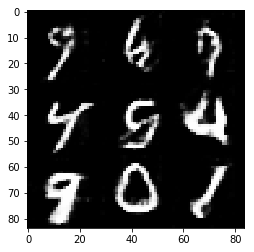

Epoch 2/2... Discriminator Loss: 1.4420... Generator Loss: 1.1303
Epoch 2/2... Discriminator Loss: 1.4819... Generator Loss: 0.8853
Epoch 2/2... Discriminator Loss: 1.3202... Generator Loss: 0.8957
Epoch 2/2... Discriminator Loss: 1.3215... Generator Loss: 0.8078
Epoch 2/2... Discriminator Loss: 1.3798... Generator Loss: 0.9026
Epoch 2/2... Discriminator Loss: 1.3663... Generator Loss: 0.8444
Epoch 2/2... Discriminator Loss: 1.4140... Generator Loss: 0.7147
Epoch 2/2... Discriminator Loss: 1.3418... Generator Loss: 0.8089
Epoch 2/2... Discriminator Loss: 1.2992... Generator Loss: 0.8294
Epoch 2/2... Discriminator Loss: 1.2975... Generator Loss: 0.7987


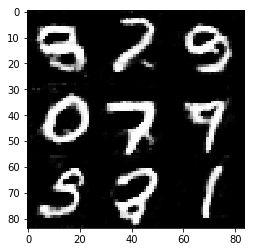

Epoch 2/2... Discriminator Loss: 1.3529... Generator Loss: 0.7455
Epoch 2/2... Discriminator Loss: 1.3035... Generator Loss: 0.8999
Epoch 2/2... Discriminator Loss: 1.3995... Generator Loss: 0.8052
Epoch 2/2... Discriminator Loss: 1.3948... Generator Loss: 0.8037
Epoch 2/2... Discriminator Loss: 1.3310... Generator Loss: 0.8514
Epoch 2/2... Discriminator Loss: 1.4190... Generator Loss: 1.1038
Epoch 2/2... Discriminator Loss: 1.3826... Generator Loss: 0.7839
Epoch 2/2... Discriminator Loss: 1.3004... Generator Loss: 0.7216
Epoch 2/2... Discriminator Loss: 1.3839... Generator Loss: 0.7573
Epoch 2/2... Discriminator Loss: 1.3611... Generator Loss: 0.7699


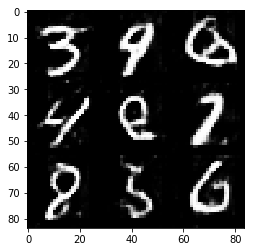

Epoch 2/2... Discriminator Loss: 1.3775... Generator Loss: 0.9019
Epoch 2/2... Discriminator Loss: 1.3267... Generator Loss: 0.8683
Epoch 2/2... Discriminator Loss: 1.3742... Generator Loss: 0.8881
Epoch 2/2... Discriminator Loss: 1.3689... Generator Loss: 0.7935
Epoch 2/2... Discriminator Loss: 1.4822... Generator Loss: 0.7516
Epoch 2/2... Discriminator Loss: 1.3353... Generator Loss: 0.7740
Epoch 2/2... Discriminator Loss: 1.4063... Generator Loss: 0.6810


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run the GANs on CelebA. 

Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 1.2943
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 1.0893
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 2.0473
Epoch 1/1... Discriminator Loss: 0.8922... Generator Loss: 2.0422
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 1.3516
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.9302
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 1.6006
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 0.9737


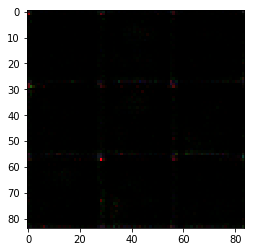

Epoch 1/1... Discriminator Loss: 0.7815... Generator Loss: 1.6789
Epoch 1/1... Discriminator Loss: 0.9710... Generator Loss: 1.7123
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 0.9228
Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 1.7691
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 1.1360
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 1.4449
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 1.7886
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 1.2571
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 0.8711


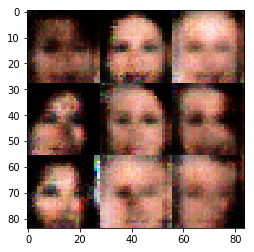

Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 1.2169
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.5988
Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 0.9458
Epoch 1/1... Discriminator Loss: 1.7113... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 1.1177
Epoch 1/1... Discriminator Loss: 0.8765... Generator Loss: 1.8926
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.9282
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.4046
Epoch 1/1... Discriminator Loss: 1.0733... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.8821


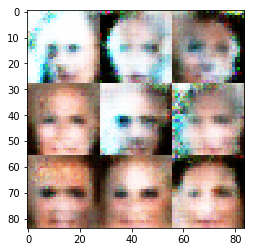

Epoch 1/1... Discriminator Loss: 1.5114... Generator Loss: 0.5550
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 1.1081
Epoch 1/1... Discriminator Loss: 1.8336... Generator Loss: 0.4723
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 1.4655
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.7363... Generator Loss: 1.1464


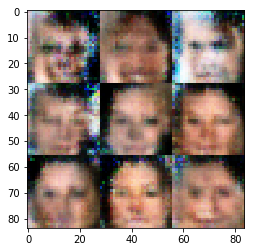

Epoch 1/1... Discriminator Loss: 1.6885... Generator Loss: 1.2551
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.8873
Epoch 1/1... Discriminator Loss: 1.7328... Generator Loss: 0.9332
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 1.5461... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.7126... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.7748... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.8278... Generator Loss: 0.5650


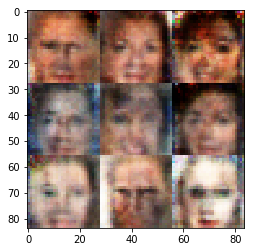

Epoch 1/1... Discriminator Loss: 1.5990... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.5385... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 1.6428... Generator Loss: 0.9367
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.8949


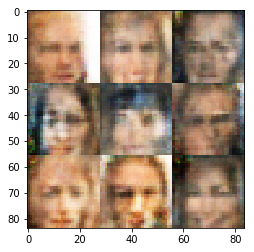

Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.6317... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.6044... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.5524... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.6134... Generator Loss: 0.6560


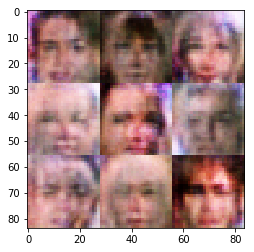

Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.8923
Epoch 1/1... Discriminator Loss: 1.5406... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.5753... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.7458


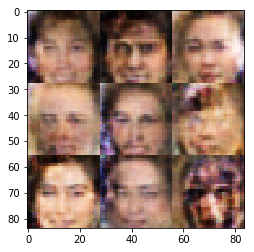

Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.5431... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7777


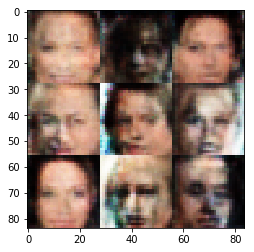

Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.5637... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.6886


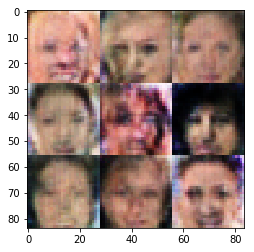

Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.4803... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.5474... Generator Loss: 0.7862


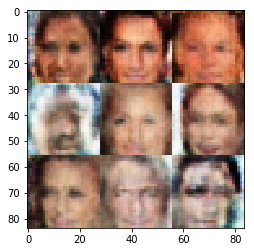

Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7162


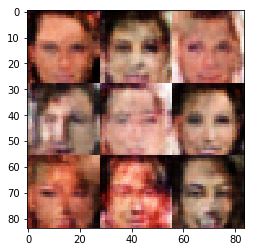

Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.5439... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.5799... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.5457... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.8001


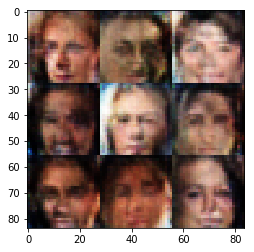

Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.7494


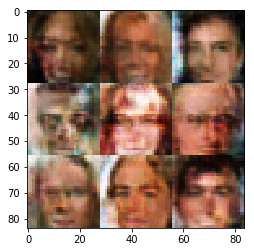

Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 0.7764


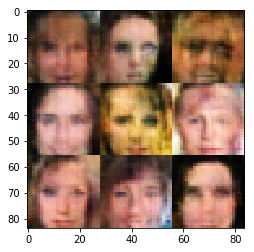

Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.7445


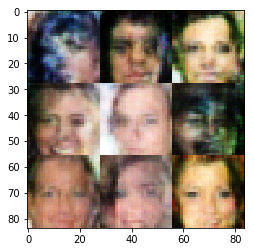

Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.5146... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.6692


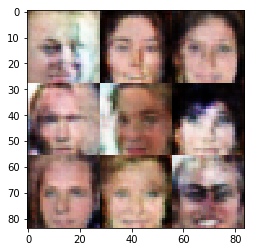

Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7539


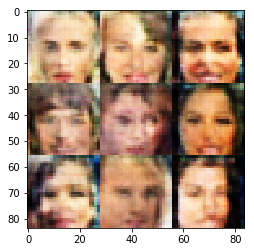

Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.7230


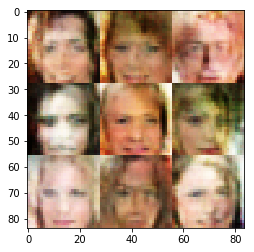

Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.7575


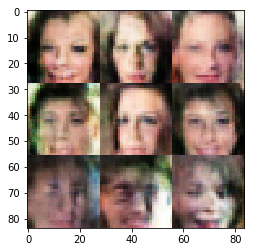

Epoch 1/1... Discriminator Loss: 1.5051... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.7584


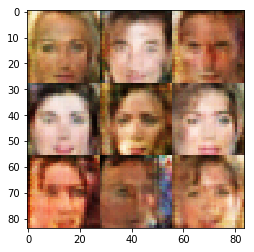

Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.7894


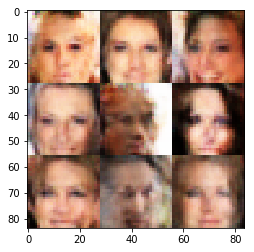

Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7457


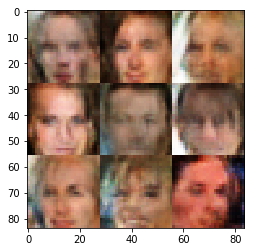

Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7082


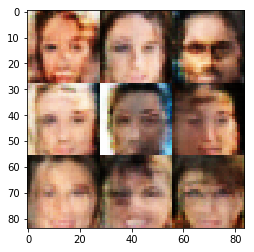

Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.5025... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.8072


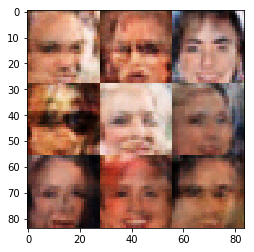

Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7453


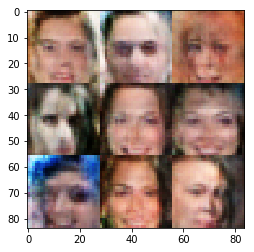

Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7051


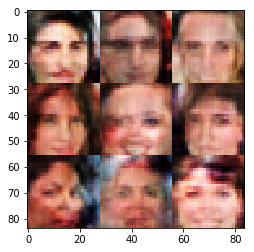

Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7916


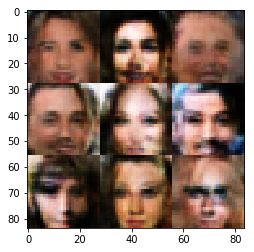

Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.7668


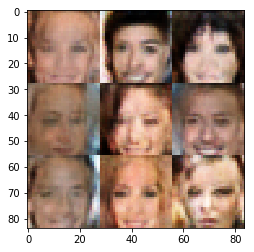

Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7283


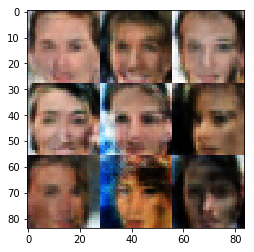

Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.7421


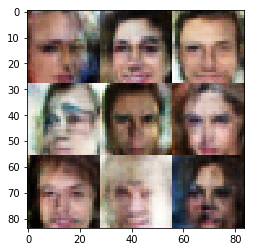

Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.8213


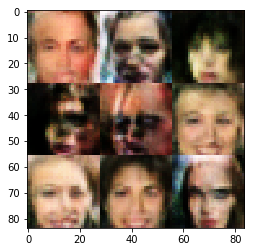

Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.6969


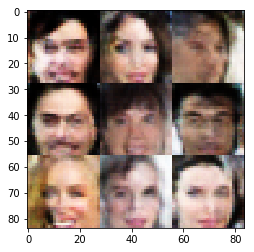

Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7022


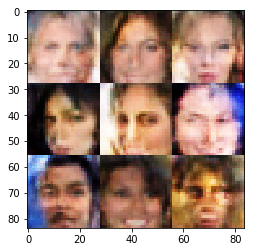

Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.6773


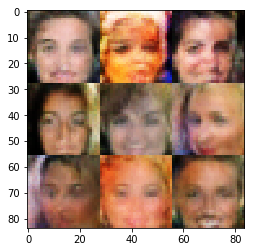

Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7590


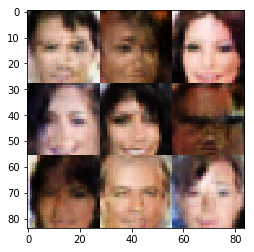

Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.7365


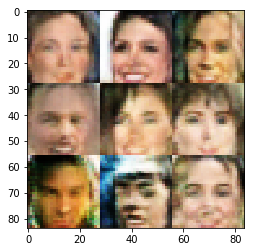

Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.7410


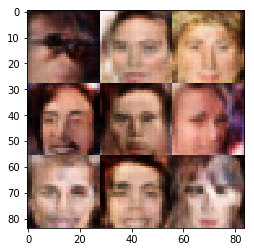

Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7013


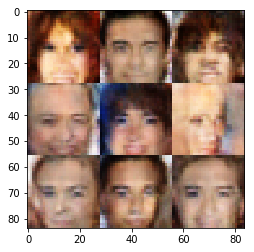

Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7959


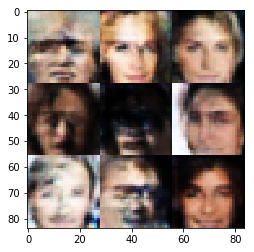

Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7769


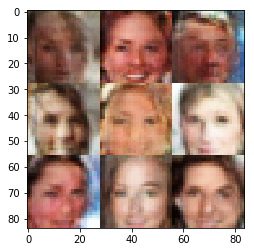

Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.8142


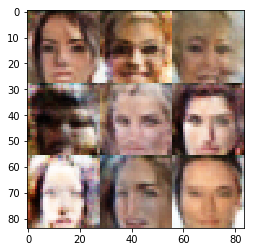

Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7533


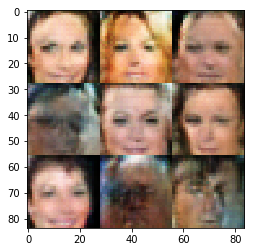

Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.7513


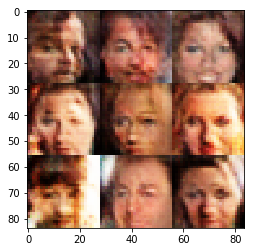

Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7503


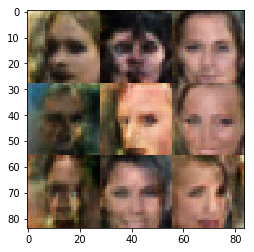

Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7465


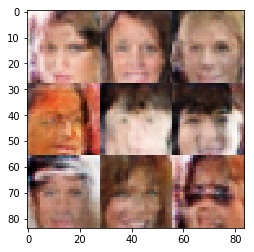

Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7425


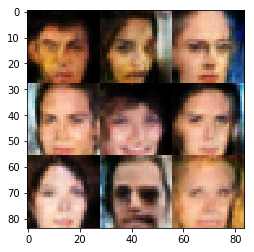

Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7242


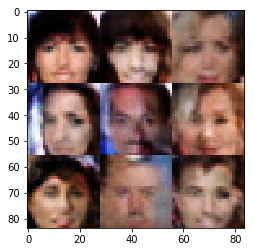

Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.7533


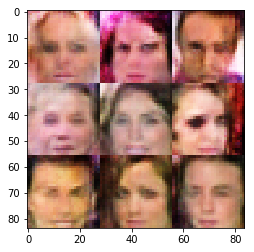

Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7906


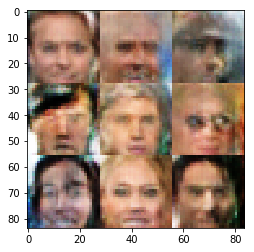

Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7974


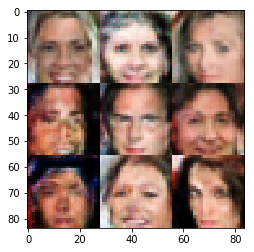

Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.7335


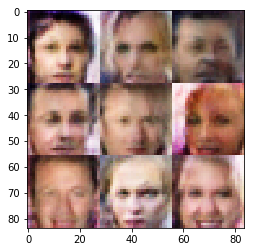

Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.8297


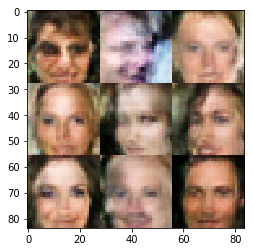

Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.7533


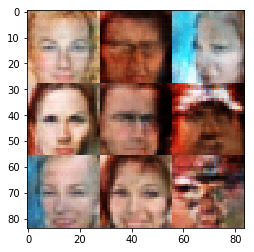

Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.9313
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.7219


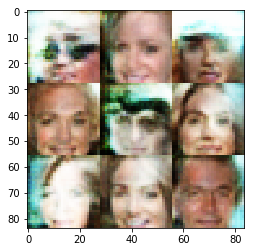

Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.8320


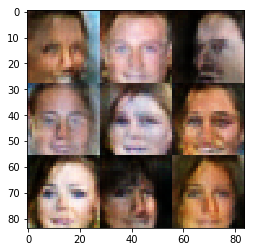

Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.7534


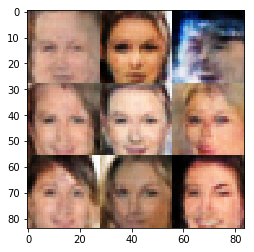

Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.7145


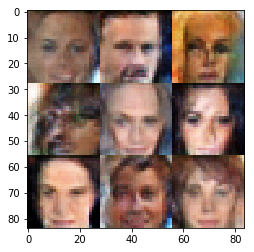

Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.8400


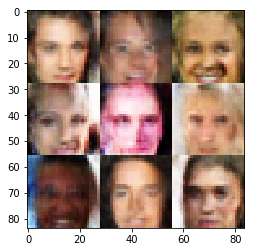

Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.8566


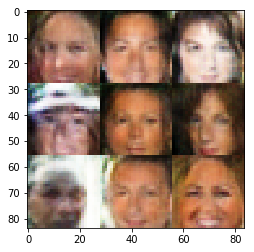

Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.8017


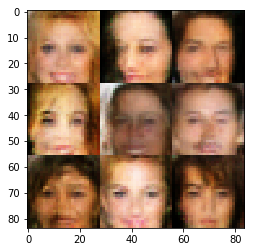

Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.8791
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.6834


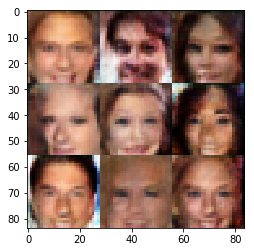

Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.8327


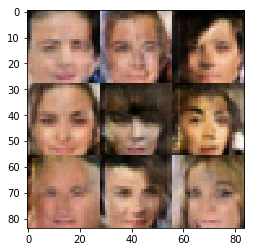

Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.7135


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)